In [1]:
from google.colab import drive
# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 18.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.metrics import specificity_score # specificity_score 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
import seaborn as sns

In [5]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample2.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample2.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_original.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_original.csv')

In [6]:
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)  # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)  # 1차원 배열(벡터)로 변환

In [7]:
# 소수 클래스와 다수 클래스 식별
target_counts = pd.Series(y_train).value_counts()
minority_class = target_counts.idxmin()
majority_class = target_counts.idxmax()

# 소수 클래스 샘플 추출
X_minority = X_train[y_train == minority_class]
X_major = X_train[y_train == majority_class]

In [8]:
# 소수 클래스와 다수 클래스를 각각 정규화
#scaler_minority = MinMaxScaler()
#scaler_majority = MinMaxScaler()

#X_minority_norm = scaler_minority.fit_transform(X_minority)
#X_majority_norm = scaler_majority.fit_transform(X_major)

In [9]:
# Xcenter 정의 (소수 클래스 평균)
Xcenter = np.mean(X_minority, axis=0)

In [10]:
Xcenter

array([-0.57888309, -0.52005149, -0.33847735, -0.09748268,  0.13704874,
        0.40168119,  0.66208967,  0.86189603,  1.0740829 ,  1.23927668,
        1.36094286,  1.3651605 ,  1.36341045,  1.33852438,  1.26798276,
        1.11426739,  0.91296771,  0.73613384,  0.53039261,  0.31402812,
        0.0950406 , -0.12992217, -0.33249066, -0.50451917, -0.55183388,
       -0.43239808, -0.24855451, -0.00903198,  0.26819275,  0.54150954,
        0.77979962,  1.03943942,  1.26240793,  1.4014703 ,  1.44962965,
        1.39875201,  1.37084002,  1.37110681,  1.33719302,  1.37381948,
        1.46154671,  1.45569567,  1.34533036,  1.10956301,  0.8187495 ,
        0.51960628,  0.20388718, -0.08277559, -0.33082356, -0.50747013,
       -0.75774464, -0.78057665, -0.83663262, -0.93133978, -1.04738218,
       -1.15739359, -1.26676342, -1.31661394, -1.30118217, -1.22214414,
       -1.1127288 , -0.9971842 , -0.88922913, -0.79005083, -0.71905749,
       -0.7245454 , -0.7851374 , -0.86258841, -0.97136142, -1.06

In [11]:
wpd_distances = []
for sample in X_minority:
    distance = dtw.distance(Xcenter, sample)
    wpd_distances.append(distance)

wpd_distances = np.array(wpd_distances)
wpd_mean = np.mean(wpd_distances)

safe_samples = X_minority[wpd_distances <= wpd_mean]
noisy_samples = X_minority[wpd_distances > wpd_mean]

In [12]:
print(len(safe_samples), len(noisy_samples))

6 6


In [13]:
# 필요한 수
n_generate = len(X_major)-len(X_minority)
samples_per_safe_point = n_generate // len(safe_samples)
remainder = n_generate % len(safe_samples)

In [14]:
augmented_samples = []

# 1차 증강
for sample in safe_samples:
    for _ in range(samples_per_safe_point):
        alpha = np.random.rand()
        new_sample = alpha * sample + (1 - alpha) * Xcenter
        augmented_samples.append(new_sample)

# 나머지 4개 생성
for i in range(remainder):
    sample = safe_samples[i % len(safe_samples)]
    alpha = np.random.rand()
    new_sample = alpha * sample + (1 - alpha) * Xcenter
    augmented_samples.append(new_sample)

augmented_samples = np.array(augmented_samples)


In [15]:
# 소수 클래스는 이미 scaler_minority 기준으로 정규화됨
X_minority_final = np.vstack([X_minority, augmented_samples])
y_minority_final = np.array([minority_class] * X_minority_final.shape[0])

# 다수 클래스도 scaler_minority 기준으로 정규화
X_majority_final = X_major
y_majority_final = np.array([majority_class] * X_majority_final.shape[0])
# 최종 통합
X_synthetic = np.vstack([X_minority_final, X_majority_final])
y_synthetic = np.concatenate([y_minority_final, y_majority_final])


In [16]:
def predict_with_logistic_regression(X_train, y_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_cart(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_knn(X_train, y_train, X_test, k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_xgboost(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def predict_with_lstm(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

def predict_with_cnn(X_train, y_train, X_test):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
    return (model.predict(X_test_reshaped) > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:11:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Logistic Regression 모델 성능:
정확도: 0.6119, F1: 0.7368, Recall: 0.8859, Specificity: 0.1777
Confusion Matrix:
[[ 59 273]
 [ 60 466]]


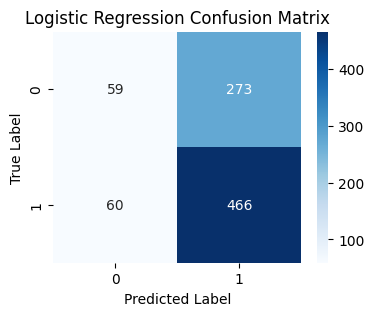

CART 모델 성능:
정확도: 0.6247, F1: 0.7538, Recall: 0.9373, Specificity: 0.1295
Confusion Matrix:
[[ 43 289]
 [ 33 493]]


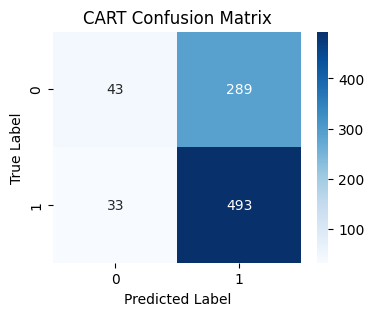

KNN 모델 성능:
정확도: 0.6678, F1: 0.7751, Recall: 0.9335, Specificity: 0.2470
Confusion Matrix:
[[ 82 250]
 [ 35 491]]


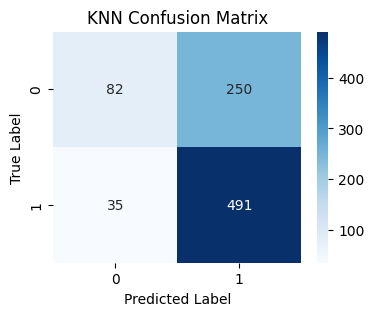

XGBoost 모델 성능:
정확도: 0.6317, F1: 0.7676, Recall: 0.9924, Specificity: 0.0602
Confusion Matrix:
[[ 20 312]
 [  4 522]]


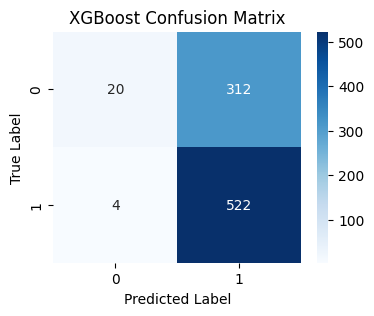

LSTM 모델 성능:
정확도: 0.5315, F1: 0.4354, Recall: 0.2947, Specificity: 0.9066
Confusion Matrix:
[[301  31]
 [371 155]]


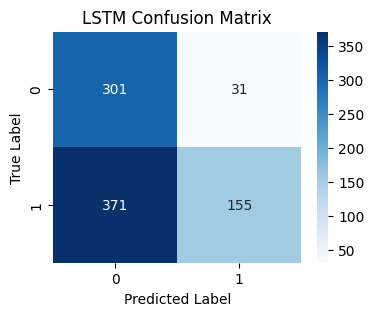

CNN 모델 성능:
정확도: 0.6410, F1: 0.7634, Recall: 0.9449, Specificity: 0.1596
Confusion Matrix:
[[ 53 279]
 [ 29 497]]


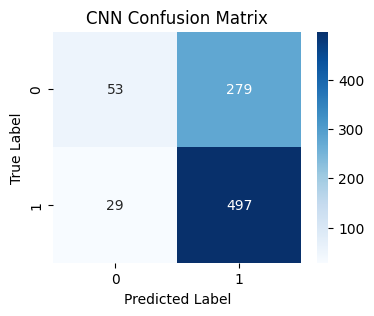

In [17]:
# 예측 실행 및 평가
predictions = {
    "Logistic Regression": predict_with_logistic_regression(X_synthetic, y_synthetic, X_test),
    "CART": predict_with_cart(X_synthetic, y_synthetic, X_test),
    "KNN": predict_with_knn(X_synthetic, y_synthetic, X_test),
    "XGBoost": predict_with_xgboost(X_synthetic, y_synthetic, X_test),
    "LSTM": predict_with_lstm(X_synthetic, y_synthetic, X_test),
    "CNN": predict_with_cnn(X_synthetic, y_synthetic, X_test),
}
# 성능 지표 저장을 위한 리스트
results = []
for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)
    results.append([accuracy, f1, recall, specificity, conf_matrix])
    print(f"{model_name} 모델 성능:")
    print(f"정확도: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


In [18]:
# 성능 지표를 DataFrame으로 변환
results_df = pd.DataFrame(results, columns=["Accuracy", "F1", "Recall", "Specificity", "Confusion Matrix"], index=predictions.keys())
model_results = results_df.T
# 결과를 출력
print("\n모델 성능 비교 결과:")
print(model_results)

# 결과를 CSV 파일로 저장
model_results.to_csv("/content/drive/My Drive/PhalangesOutlinesCorrect/results/msmote_models_result.csv")


모델 성능 비교 결과:
                     Logistic Regression                    CART  \
Accuracy                        0.611888                0.624709   
F1                              0.736759                0.753823   
Recall                          0.885932                0.937262   
Specificity                     0.177711                0.129518   
Confusion Matrix  [[59, 273], [60, 466]]  [[43, 289], [33, 493]]   

                                     KNN                XGBoost  \
Accuracy                        0.667832               0.631702   
F1                              0.775059               0.767647   
Recall                           0.93346               0.992395   
Specificity                     0.246988               0.060241   
Confusion Matrix  [[82, 250], [35, 491]]  [[20, 312], [4, 522]]   

                                     LSTM                     CNN  
Accuracy                         0.531469                0.641026  
F1                               0.435